In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import missingno as msno
plt.style.use('ggplot')

# Preparing Data

In [2]:
fp = ('https://raw.githubusercontent.com/alexeygrigorev/datasets'
      '/master/AER_credit_card_data.csv')

df = pd.read_csv(fp)
df.sample(n=5)

,card,reports,age,income,share,expenditure,owner,selfemp,dependents,months,majorcards,active
1046,yes,0,23.91667,2.0000,0.100191,166.9017,no,no,0,9,1,0
69,yes,0,24.66667,3.0740,0.250803,642.4742,no,no,0,4,1,0
934,yes,1,23.25000,1.8769,0.353630,553.1067,no,no,0,12,1,3
1151,no,0,42.00000,3.4000,0.000353,0.0000,yes,no,3,5,1,9
566,yes,3,47.50000,3.1000,0.179285,463.1517,no,no,0,24,1,15


### Checking missing values

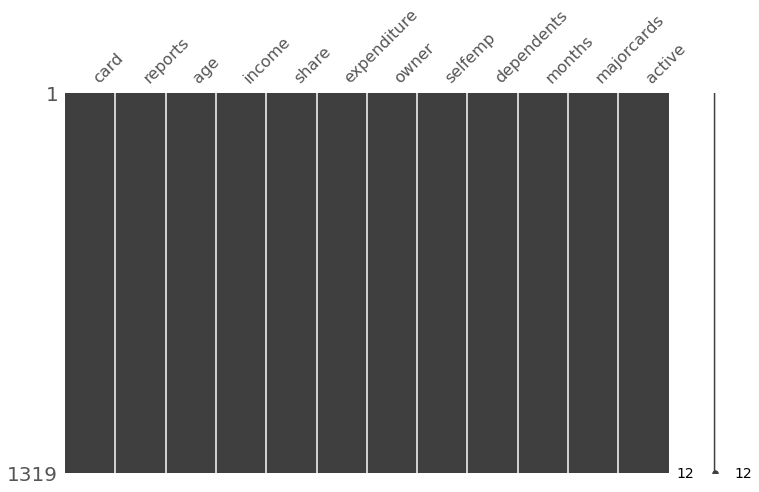

In [3]:
msno.matrix(df, figsize=(12, 7));

The data set contains no missing values.

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1319 entries, 0 to 1318
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   card         1319 non-null   object 
 1   reports      1319 non-null   int64  
 2   age          1319 non-null   float64
 3   income       1319 non-null   float64
 4   share        1319 non-null   float64
 5   expenditure  1319 non-null   float64
 6   owner        1319 non-null   object 
 7   selfemp      1319 non-null   object 
 8   dependents   1319 non-null   int64  
 9   months       1319 non-null   int64  
 10  majorcards   1319 non-null   int64  
 11  active       1319 non-null   int64  
dtypes: float64(4), int64(5), object(3)
memory usage: 123.8+ KB


In [5]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
reports,1319.0,0.456406,1.345267,0.000000,0.000000,0.000000,0.000000,14.00000
age,1319.0,33.213103,10.142783,0.166667,25.416670,31.250000,39.416670,83.50000
income,1319.0,3.365376,1.693902,0.210000,2.243750,2.900000,4.000000,13.50000
share,1319.0,0.068732,0.094656,0.000109,0.002316,0.038827,0.093617,0.90632
expenditure,1319.0,185.057071,272.218917,0.000000,4.583333,101.298300,249.035800,3099.50500
dependents,1319.0,0.993935,1.247745,0.000000,0.000000,1.000000,2.000000,6.00000
months,1319.0,55.267627,66.271746,0.000000,12.000000,30.000000,72.000000,540.00000
majorcards,1319.0,0.817286,0.386579,0.000000,1.000000,1.000000,1.000000,1.00000
active,1319.0,6.996967,6.305812,0.000000,2.000000,6.000000,11.000000,46.00000


We can notice that the numerical features have a large variation, since the chosen model is a logistic regression, it will be better to scale these features. Also `dependents` and `majorcards` features should be categorical not numerical.

In [6]:
df['owner'].value_counts()

no     738
yes    581
Name: owner, dtype: int64

In [7]:
df['selfemp'].value_counts()

no     1228
yes      91
Name: selfemp, dtype: int64

In [8]:
df['majorcards'].value_counts()

1    1078
0     241
Name: majorcards, dtype: int64

In [9]:
df['dependents'].value_counts()

0    659
1    267
2    218
3    115
4     44
5      9
6      7
Name: dependents, dtype: int64

### Mapping target variable

In [10]:
df['card'].value_counts()

yes    1023
no      296
Name: card, dtype: int64

The target variable `card` and the categorical feature `selfemp` are clearly imbalanced. They can therefore easily define **unfair behavior** on the model.

In [11]:
data, target = df.drop(columns=['card']), df['card'].map({'yes':1, 'no':0})

### Numerical and categorical features separation

In [12]:
from sklearn.compose import make_column_selector as selector

numerical = selector(dtype_include=np.number)(data)
categorical = selector(dtype_include=object)(data)

### Split data set

In [13]:
from sklearn.model_selection import train_test_split

df_full_train, df_test, y_full_train, y_test = train_test_split(
    data,
    target,
    test_size=.2,
    random_state=1,
    # stratify=target
)

dev_size = df_test.shape[0] / df_full_train.shape[0]

df_train, df_dev, y_train, y_dev = train_test_split(
    df_full_train,
    y_full_train,
    test_size=dev_size,
    random_state=1,
    # stratify=y_full_train
)

df_train.shape, y_train.shape, df_dev.shape, y_dev.shape, df_test.shape, y_test.shape

((791, 11), (791,), (264, 11), (264,), (264, 11), (264,))

# **Question 1**

Which numerical variable (among the following 4) has the highest AUC?

- reports
- dependents
- active
- share


In [14]:
from sklearn.metrics import roc_auc_score

def evaluate_feature_importance(df, features, target='card'):
  evaluation = {}
  for f in features:
    if roc_auc_score(df[target], df[f]) < .5:
      evaluation[f] = roc_auc_score(df[target], -df[f])
    else:
      evaluation[f] = roc_auc_score(df[target], df[f])
  
  return evaluation


In [15]:
evaluation = evaluate_feature_importance(df, numerical)
evaluation

{'reports': 0.7178013790917016,
 'age': 0.5013754590367494,
 'income': 0.5888896594541755,
 'share': 0.9898054212570342,
 'expenditure': 0.9897360703812317,
 'dependents': 0.5257721064172676,
 'months': 0.5178826186890704,
 'majorcards': 0.5499111648305197,
 'active': 0.5824680985971309}

In [16]:
ev_filtred = { f: evaluation[f] for f in ['reports', 'dependents', 'active', 'share'] }
max(ev_filtred, key=ev_filtred.get)

'share'

# **Question 2**
What's the AUC of this model on the validation dataset?

In [17]:
all_features = numerical + categorical

In [18]:
from sklearn.linear_model import LogisticRegression
from sklearn.feature_extraction import DictVectorizer

dv = DictVectorizer(sparse = False)

train_dico = df_train[all_features].to_dict(orient= 'records')
X_train = dv.fit_transform(train_dico)

dev_dico = df_dev[all_features].to_dict(orient = 'records')
X_dev = dv.transform(dev_dico)

model = LogisticRegression(solver='liblinear', C=1.0, max_iter=1000)
model.fit(X_train, y_train)

y_dev_pred = model.predict_proba(X_dev)[:, 1]

roc_auc_score(y_dev, y_dev_pred).round(3)

0.995

# **Question 3**

At which threshold precision and recall curves intersect?

In [19]:
def precision_and_recall(y_true, y_pred, graph=False):
  metrics = []
  threshold = np.linspace(0, 1, num=101, endpoint=True)
  
  for thresh in threshold:
    actual_pos = y_true == 1
    actual_neg = y_true == 0

    predicted_pos = y_pred >= thresh
    predicted_neg = y_pred < thresh

    TP = (actual_pos & predicted_pos).sum()
    TN = (actual_neg & predicted_neg).sum()
    
    FP = (actual_neg & predicted_pos).sum()
    FN = (actual_pos & predicted_neg).sum()
    
    precision = TP / (TP + FP)
    recall = TP/ (TP + FN)

    metrics.append((thresh, precision, recall))
    df_metrics = pd.DataFrame(
        metrics, 
        columns=['threshold', 'precision', 'recall'])
  
  if graph:
    plt.figure(figsize=(8, 5), dpi=105)
    plt.plot(df_metrics['threshold'], df_metrics['precision'], label='Precision')
    plt.plot(df_metrics['threshold'], df_metrics['recall'], label='Recall')
    plt.xlabel('Threshold')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.show()

  return df_metrics

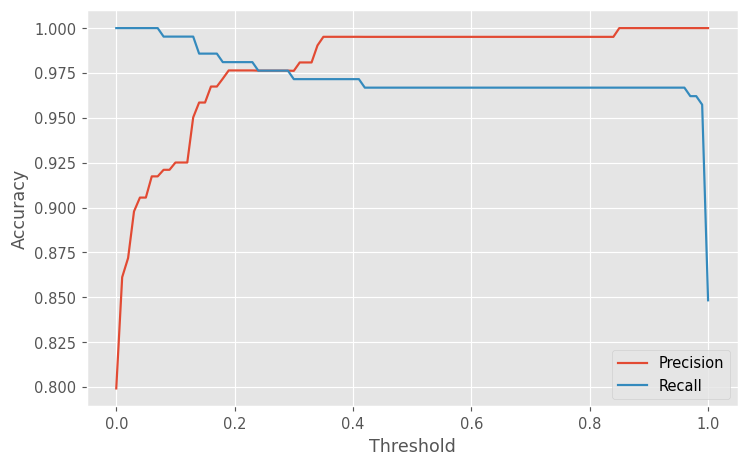

,threshold,precision,recall
0,0.00,0.799242,1.000000
1,0.01,0.861224,1.000000
2,0.02,0.871901,1.000000
3,0.03,0.897872,1.000000
4,0.04,0.905579,1.000000
...,...,...,...
96,0.96,1.000000,0.966825
97,0.97,1.000000,0.962085
98,0.98,1.000000,0.962085
99,0.99,1.000000,0.957346


In [20]:
precision_and_recall(y_dev, y_dev_pred, graph=True)